<center><h1>  VAERS Data Set </h1></center>

# Import labraries

In [1]:
# Import used labraries
import pandas as pd 
import numpy as np 
from sklearn.model_selection import KFold # kfold for model validation
from sklearn.model_selection import train_test_split # for data spliting
from sklearn.preprocessing import StandardScaler # for data normalization 
import matplotlib.pyplot as plt

# Sklearn modules 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Sklearn accuracy 
from sklearn.metrics import accuracy_score
from collections import Counter

# Automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures


# Import Regularized regression function
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

# ML pipeline
from sklearn.pipeline import make_pipeline

#set display 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load the CSN files into dataframs 

In [2]:
# Load csv into dataframes 
df_data = pd.read_csv("../dat/2021VAERSDATA.csv", sep=',',thousands=',', error_bad_lines=False, index_col=False, dtype='unicode')
df_sympt = pd.read_csv("../dat/2021VAERSSYMPTOMS.csv", sep=',',thousands=',', error_bad_lines=False, index_col=False, dtype='unicode')

# use this df to select covid19 vaccines
df_vax = pd.read_csv("../dat/2021VAERSVAX.csv", sep=',',thousands=',', error_bad_lines=False, index_col=False, dtype='unicode')

## check the data frames shapes

In [3]:
# print shape info for each dataframe 
print('2021VAERSDATA shape ',df_data.shape[0],' rows ' ,df_data.shape[1],' columns ') 
print('2021VAERSSYMPTOMS shape ',df_sympt.shape[0],' rows ' ,df_sympt.shape[1],' columns ') 
print('2021VAERSVAX shape ',df_vax.shape[0],' rows ' ,df_vax.shape[1],' columns ')

2021VAERSDATA shape  747180  rows  35  columns 
2021VAERSSYMPTOMS shape  999509  rows  11  columns 
2021VAERSVAX shape  791183  rows  8  columns 


# Data Pre-processing

## Selecting COVID-19 Vaccines

In [4]:
# select covid19 vaccines which are used in germany 'PFIZER\\BIONTECH' 'MODERNA' 'JANSSEN' AstraZeneca is not listed here !
vax_names = ['PFIZER\\BIONTECH','MODERNA','JANSSEN']
df_vax_cols = ['VAERS_ID','VAX_MANU']
#  & (df_vax['VAX_DOSE_SERIES'] == '3') & (df_vax['VAX_MANU'].isin(vax_names))
df_tep = df_vax[(df_vax['VAX_TYPE'] == 'COVID19')& ((df_vax['VAX_DOSE_SERIES'] == '3') | (df_vax['VAX_DOSE_SERIES'] =='JANSSEN'))]
df_vax_selected = df_tep[df_vax_cols]
df_vax_selected.VAX_MANU = "Y" #pd.Categorical(df_vax_selected['VAX_MANU'])
#df_vax_selected.VAX_MANU = df_vax_selected.VAX_MANU.cat.codes
df_vax_selected.VAERS_ID = df_vax_selected.VAERS_ID.astype('str')

df_vax_selected.reset_index(drop=True, inplace=True)


C:\Users\eliaa\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Check data Form and get the unique values

In [5]:
df_vax_selected.head()
df_vax_selected['VAX_MANU'].value_counts()[:5].sort_values(ascending=False)

Y    37797
Name: VAX_MANU, dtype: int64

## Selecting the interessting Columns form Symptoms dataframe 

In [6]:
# select the top 7 common symptoms 
# selcted_symptoms =  ['Chills', 'Pyrexia', 'Dizziness', 'Fatigue', 'Headache', 'Pain in extremity', 'Nausea']

# def selector(row):
#     selcted_symptoms =  ['Chills', 'Pyrexia', 'Dizziness', 'Fatigue', 'Headache', 'Pain in extremity', 'Nausea']
#     if row.isin(selcted_symptoms):
#         return row
#     else:
#         return 'Other'

symptoms_selected_cols = ['VAERS_ID','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']
# symptoms_cols = ['SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']
df_sympt_filter = df_sympt[symptoms_selected_cols]
# for x in symptoms_cols:
#     df_sympt_filter[x] = df_sympt_filter.apply( lambda row : selector(row), axis = 1)

### Count the number of the symptoms pre patient ID 

In [7]:
df_sympt_filter['NUM_OF_SYM'] = df_sympt_filter.count(axis=1)
# the ID is also counted with non-null columns so we substact 1 to obtain the right value 
df_sympt_filter['NUM_OF_SYM_SUB'] = df_sympt_filter['NUM_OF_SYM'].apply(lambda x : x -1)
df_sympt_filter.head()

<ipython-input-7-9758fb4450d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sympt_filter['NUM_OF_SYM'] = df_sympt_filter.count(axis=1)
<ipython-input-7-9758fb4450d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sympt_filter['NUM_OF_SYM_SUB'] = df_sympt_filter['NUM_OF_SYM'].apply(lambda x : x -1)


,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,NUM_OF_SYM,NUM_OF_SYM_SUB
0,0916600,Dysphagia,Epiglottitis,NaN,NaN,NaN,3,2
1,0916601,Anxiety,Dyspnoea,NaN,NaN,NaN,3,2
2,0916602,Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN,5,4
3,0916603,Dizziness,Fatigue,Mobility decreased,NaN,NaN,4,3
4,0916604,Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN,5,4


### Selecting only patient ID and the number of symptoms 

In [8]:
df_sympt_filter_final = df_sympt_filter [['VAERS_ID','NUM_OF_SYM_SUB']]
#df_sympt_filter_selected = df_sympt_filter[symptoms_selected_cols]
df_sympt_filter_final.head()

,VAERS_ID,NUM_OF_SYM_SUB
0,0916600,2
1,0916601,2
2,0916602,4
3,0916603,3
4,0916604,4


## Cleaning Patient Dataframe 

In [9]:
"""
Plot a the number of unique values that are contained in a column 
"""
def plot_frec_col(df, colName):
    # plot the histogram of frequencies of values in column label

    # convert the column to a list 
    arr_label = df[colName].to_list()

    # count the values of the prev. list 
    label_labels, label_counts = np.unique(arr_label, return_counts=True)

    # set the general font size to 16
    plt.rcParams['font.size'] = '16'

    # set the figure size 
    plt.figure(figsize=(12,8))

    # plot the values as bar histogram 
    plt.bar(label_labels, label_counts, align='center')

    # set the title of the plot and axes names
    tit = 'Histogram of column '+ str(colName)
    plt.title(tit,fontsize=25)
    plt.xlabel(colName)
    plt.ylabel('frequency')
    plt.setp(plt.gca().get_xticklabels(), rotation=70, horizontalalignment='right')
    plt.gca().set_xticks(label_labels)

    # show the plot 
    plt.show()

In [10]:
"""
Show the number of unique values contained in a data frame
If the column has more than 52 values it will be not shown 
"""
def df_Stat(df):
    # list of dataframe colums names
    col_names=list(df.columns)

    # data types of columns 
    te = list(map(str,df.dtypes))

    # create a list of directories
    dic_list=[]

    # itrate over columns names list and datatypes list and add the entries to a directory and then add this dict. to a list
    for c,t in zip(col_names,te):
        dict_cols_stat = {"name":c,"num_of_distinct_values":len(list(df[c].unique())),"dtype":t}
        dic_list.append(dict_cols_stat)

    # create a new dataframe 
    col_stat_df = pd.DataFrame()

    # for each dict. in dict. list add to the last dataframe 
    for l in dic_list:
        col_stat_df=col_stat_df.append(l, ignore_index=True)
    
    # show column name, its datatype and how many distinct values it has 
    df_st= (col_stat_df[['name','dtype','num_of_distinct_values']]
    .where(col_stat_df.num_of_distinct_values<52)
    .sort_values('num_of_distinct_values').dropna())

    return df_st



### Show patient data frame statistic using the function `df_Stat`

In [11]:
df_Stat(df_data)

,name,dtype,num_of_distinct_values
9,DIED,object,2.0
11,L_THREAT,object,2.0
12,ER_VISIT,object,2.0
13,HOSPITAL,object,2.0
15,X_STAY,object,2.0
16,DISABLE,object,2.0
29,FORM_VERS,object,2.0
31,BIRTH_DEFECT,object,2.0
32,OFC_VISIT,object,2.0
33,ER_ED_VISIT,object,2.0


### Copy the data frame to a new data frame

In [12]:
# After cleaning select top 10 + Unknown
df_data_clean = df_data

### Create Hash Map for replacing the Redundant String in HISTORY and CUR_ILL columns

In [13]:

#df_data['HISTORY'].value_counts()[:20].sort_values(ascending=False)
replace_dist_history= {
    'None':'Unknown',
    'none': 'Unknown',
    'Comments: Unknown':'Unknown',
    'No':'Unknown',
    'asthma':'Asthma',
    'mild asthma':'Asthma',
    'Asthma.':'Asthma',
    'Medical History/Concurrent Conditions: Asthma':'Asthma',
    'no':'Unknown',
    'NONE':'Unknown',
    'none.':'Unknown',
    'unknown':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event':'Unknown',
    'Comments: No medical history was provided by the reporter.':'Unknown',
    'hypertension': 'Hypertension',
    'Medical History/Concurrent Conditions: Hypertension': 'Hypertension',
    'None.' : 'Unknown',
    'diabetes': 'Diabetes',
    'Type 1 diabetes': 'Diabetes',
    'Diabetes type 2': 'Diabetes',
    'Diabetes Type 2': 'Diabetes',
    'Type 1 Diabetes': 'Diabetes',
    'Type 2 Diabetes':'Diabetes',
    'Type 2 diabetes':'Diabetes',
    'Medical History/Concurrent Conditions: Diabetes': 'Diabetes',
    'Medical History/Concurrent Conditions: No adverse event (No reported medical history)':'Unknown',
    'Medical History/Concurrent Conditions: Anxiety':'Anxiety',
    'High blood pressure':'Hypertension',
    'HIGH BLOOD PRESSURE':'Hypertension',
    'HYPERTENSION':'Hypertension',
    'high blood pressure':'Hypertension',
    'High Blood Pressure' : 'Hypertension',
    'High blood pressure.': 'Hypertension',
    'High BP':'Hypertension',
    'Medical History/Concurrent Conditions: Blood pressure high':'Hypertension',
    'hypothyroidism': 'Hypothyroidism',
    'Medical History/Concurrent Conditions: COVID-19':'COVID-19',
    'Medical History/Concurrent Conditions: COVID-19 (Prior to vaccination, was the patient diagnosed with COVID-19?:Yes)':'COVID-19',
    'Medical History/Concurrent Conditions: COVID-19 (Prior to vaccination, was the patient diagnosed with COVID-19?: Yes)':'COVID-19',
    'Medical History/Concurrent Conditions: No adverse event (No medical history reported)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No reported medical history.)' : 'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: none':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None, Comment: Patient History: No':'Unknown',
    'Medical History/Concurrent Conditions: Rheumatoid arthritis':'Rheumatoid Arthritis',
    'Comments: No medical history was reported by the reporter.':'Unknown',
    'Comments: No medical history information was reported.':'Unknown',
    'Medical History/Concurrent Conditions: Migraine':'Migraines',
    'Mild asthma':'Asthma',
    'NONE REPORTED':'Unknown',
    'none listed':'Unknown',
    'denies':'Denies',
    'Comments: The patient had no known allergies.':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no reported medical history)':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No recorded medical history)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no medical history provided)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no medical history reported)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history provided)':'Unknown',
    'Comments: No Medical History Information was reported.':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None.':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: No':'Unknown',
    'Medical History/Concurrent Conditions: No adverse reaction':'Unknown',
    'Comments: No medical history was reported':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history was reported.':'Unknown',
    'Not known':'Unknown',
    'NOT KNOWN':'Unknown',
    'None Reported':'Unknown',
    'None Known':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event.':'Unknown',
    'rheumatoid arthritis':'Rheumatoid Arthritis',
    'Medical History/Concurrent Conditions: Depression':'Depression',
    'Comments: No Medical History was provided by the reporter.':'Unknown',
    'diabetic':'Diabetic',
    'Comments: Medical history was not provided.':'Unknown',
    'Comments: No medical history was provided by reporter.':'Unknown',
    'Medical History/Concurrent Conditions: Arthritis':'Arthritis',
    'Comments: No medical history was provided by the reporter':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history reported.)':'Unknown',
    'Comments: No medical history reported.':'Unknown',
    'Comments: No Medical History information was reported.' : 'Unknown',
    'Comments: No medical history was reported.':'Unknown',
    'Medical History/Concurrent Conditions: Penicillin allergy' : 'Allergy',
    'Medical History/Concurrent Conditions: Hypothyroidism' : 'Hypothyroidism',
    'UNKNOWN':'Unknown',
    'N/a':'Unknown',
    'None reported':'Unknown',
    'none known':'Unknown',
    'NO':'Unknown',
    'none reported':'Unknown',
    'na':'Unknown',
    'Na':'Unknown',
    'None known':'Unknown',
    'Comments: None':'Unknown',
    'migraines':'Migraines',
    'Rheumatoid arthritis' : 'Rheumatoid Arthritis',
    'arthritis':'Arthritis',
    'obesity':'Obesity',
    'Medical History/Concurrent Conditions: Sulfonamide allergy':'Allergy',
    'Medical History/Concurrent Conditions: Allergy':'Allergy',
    'anxiety':'Anxiety',
    'hypothyroid':'Hypothyroid',
    'high cholesterol':'High cholesterol',
    'Migraine':'Migraines',
    'migraine':'Migraines',
    'ASTHMA':'Asthma',
    'See above':'Unknown',
    'No.':'Unknown',
    'see above':'Unknown',
    'not known':'Unknown',
    'none.':'Unknown',
    '0':'Unknown',
    'depression':'Depression',
    'seasonal allergies':'Allergy',
    'Seasonal allergies':'Allergy',
    'Seasonal Allergies':'Allergy',
    'Penicillin allergy':'Allergy',
    'Medical History/Concurrent Conditions: Seasonal allergy':'Allergy',
    'Medical History/Concurrent Conditions: Drug allergy':'Allergy',
    'Medical History/Concurrent Conditions: Shellfish allergy':'Allergy',
    'Medical History/Concurrent Conditions: Penicillin allergy (Known allergies: Penicillin)':'Allergy',
    'Medical History/Concurrent Conditions: Food allergy':'Allergy',
    'allergies':'Allergy',
    'Medical History/Concurrent Conditions: Shingles': 'Shingles',
    'Medical History/Concurrent Conditions: Cancer':'Cancer',
    'Medical History/Concurrent Conditions: Breast cancer':'Cancer',
    'None listed':'Unknown',
    'Unknown.':'Unknown',
    'GERD':'Gerd',
    'eczema':'Eczema',
    'unk':'Unknown',
    'none noted':'Unknown',
    'same as above':'Unknown',
    'Yes':'Unknown',
    'overweight':'Overweight',
    'UNK':'Unknown',
    'None noted':'Unknown',
    'Comments: No medical history was provided.':'Unknown',
    'Copd':'COPD',
    'copd':'COPD',
    'Medical History/Concurrent Conditions: COPD':'COPD',
    'epilepsy':'Epilepsy',
    'htn':'HTN',
    'Same as above':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history was reported.)':'Unknown',
    'Non':'Unknown',
    'Nothing':'Unknown',
    'NONE KNOWN':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no historical condition was reported)':'Unknown',
    'no known illnesses':'Unknown',
    'No known illnesses':'Unknown',
    'non':'Unknown',
    'None documented':'Unknown',
    'nothing':'Unknown',
    'None known.':'Unknown',
    'No known':'Unknown',
    'no known':'Unknown',
    '-':'Unknown',
    'No other illnesses':'Unknown',
    'None reported.':'Unknown',
    'Not reported':'Unknown',
    'I was not experiencing any illness.':'Unknown',
    'No other illnesses.':'Unknown',
    'no illnesses':'Unknown',
    'NOT REPORTED':'Unknown',
    'No e':'Unknown',
    'No acute illnesses':'Unknown',
    'I did not have any other illnesses.':'Unknown',
    'NONE.':'Unknown',
    'Not applicable':'Unknown',
    'Nine':'Unknown',
    'ORIGINAL ON FILE AT FACILITY':'Unknown',
    'No acute illness':'Unknown',
    'NOne':'Unknown',
    'none stated':'Unknown',
    'no known illnesses':'Unknown',
    'None stated':'Unknown',
    '?':'Unknown',
    'no acute illness':'Unknown',
    'no illness':'Unknown',
    'No illnesses at the time of vaccination.':'Unknown',
    'N/A.':'Unknown',
    'No illnesses.':'Unknown',
    'unkown':'Unknown',
    'NONE LISTED':'Unknown',
    'Unk':'Unknown',
    'no acute illnesses':'Unknown',
    'Zero':'Unknown',
    'No illness date of vaccination, unknown prior':'Unknown',
    'None disclosed':'Unknown',
    'Nope':'Unknown',
    'None per patient':'Unknown',
    'None Documented':'Unknown',
    'Unkown':'Unknown',
    'no other illnesses':'Unknown',
    'none disclosed':'Unknown',
    'No Other illnesses at the time of vaccination and up to one month prior.':'Unknown',
    'none per patient':'Unknown',
    'NONE NOTED':'Unknown',
    'None that I am aware of':'Unknown',
    'None noted.':'Unknown',
    'none indicated':'Unknown',
    'none at time of vaccination':'Unknown',
    'No known illnesses.':'Unknown',
    'No known illness':'Unknown',
    'Uknown':'Unknown',
    'none documented':'Unknown',
    'No Known':'Unknown',
    'unsure':'Unknown',
    'None reported on prescreen.':'Unknown',
    'no known illness':'Unknown',
    'UNKOWN':'Unknown',
    'Not Known':'Unknown',
    'No other illness':'Unknown',
    'n/A':'Unknown',
    'undisclosed':'Unknown',
    'NK':'Unknown',
    'no.':'Unknown',
    'Not available':'Unknown',
    'not applicable':'Unknown',
    'See below':'Unknown',
    'none given':'Unknown',
    'NO KNOWN':'Unknown',
    'None on file':'Unknown',
    'None Stated':'Unknown',
    'Unsure':'Unknown',
    'NON':'Unknown',
    'Not Applicable':'Unknown',
    'None that I am aware of.':'Unknown',
    'None reported by patient':'Unknown',
    'not sure':'Unknown',
    'Nothing.':'Unknown',
    '.':'Unknown',
    'unknown.':'Unknown',
    'None to my knowledge':'Unknown',
    'None that I know of':'Unknown',
    'none that I am aware of':'Unknown',
    'None indicated':'Unknown',
    'None Noted':'Unknown',
    'None mentioned':'Unknown',
    'Nond':'Unknown',
    'No acute illness':'Unknown',
    'Nobe':'Unknown',
    'I was not experiencing any illness at the time.':'Unknown',
    'nonw':'Unknown',
    'Nonw':'Unknown',
    'UKN':'Unknown',
    'N?A':'Unknown',
    'none mentioned':'Unknown',
    'not reported':'Unknown',
    'Mone':'Unknown',
    'not available':'Unknown',
    'see below':'Unknown',
    'I did not have any illness.':'Unknown',
    'None aware of ':'Unknown',
    'No acute illnesses.':'Unknown',
    'Nonr':'Unknown',
    'Nome':'Unknown',
    'No illness.':'Unknown',
    'No acute illness.':'Unknown',
    'I did not have any illnesses.':'Unknown',
    'None aware of':'Unknown',
    'N\A':'Unknown',
    'No other illnesses at the time of vaccination.':'Unknown',
    'nothing acute':'Unknown',
    'None stated.':'Unknown',
    'None identified':'Unknown',
    '--':'Unknown',
    'None!':'Unknown',
    'None,':'Unknown',
    'None that we are aware of':'Unknown',
    'NO KNOWN ILLNESSES':'Unknown',
    'none at the time of vaccination':'Unknown',
    'None to report':'Unknown',
    'None Listed':'Unknown',
    'none identified':'Unknown',
    'No current illness':'Unknown',
    'NONe':'Unknown',
    'None reported by client.':'Unknown',
    'Not aware of any':'Unknown',
    'O':'Unknown',
    'no acute':'Unknown',
    'Not applicable. Dose administered too soon.':'Unknown',
    'not aware of':'Unknown',
    'one':'Unknown',
    'None that I know of.':'Unknown',
    'none reported by patient ':'Unknown'

}


### Replace the values in HISTORY columns using the Hash Map
We have decided to use HISTORY as a binary variable where N means no pre-existing conditions and Y means there is. 

We do this step to gain as much as possible data to fit them in our models. 

In [14]:
df_data_clean['HISTORY'] = df_data_clean['HISTORY'].replace(replace_dist_history)

#df_data_clean['HISTORY'].value_counts()[:20].sort_values(ascending=False)

def history_to_bin(x):
    if x == 'Unknown':
        return 'N'
    else:
        return 'Y'
df_data_clean['HISTORY'] = df_data_clean['HISTORY'].apply(lambda x : history_to_bin(x))
#df_data_clean.head()


### Create Hasp map for OTHER_MEDS column

Here we follow the same strategy as by history column

In [15]:
# merging the dataframe to create a dataframe to use in fitting our pre-selected models
replace_dist_OTHER_MEDS = {
  'none':'None',
  'unknown':'None',
  'Unknown':'None',
  'No':'None',
  'NONE':'None',
  'no':'None',
  'UNKNOWN':'None',
  'None.':'None',
  'N/a':'None',
  'None reported':'None',
  'na':'None',
  'Not known':'None',
  'unkown':'None',
  'Na':'None',
  'Yes':'None',
  'NA':'None',
  'synthroid':'Synthroid',
  'None listed':'None',
  'NO':'None',
  'ibuprofen':'Ibuprofen',
  'none reported':'None',
  'none known':'None',
  'None known':'None',
  'NONE REPORTED':'None',
  'not known':'None',
  'Nothing':'None',
  'NOT KNOWN':'None',
  'nothing':'None',
  'None noted':'None',
  'None Known':'None',
  'tylenol':'Tylenol',
  '0':'None',
  'Unk':'None',
  'ZYRTEC [CETIRIZINE HYDROCHLORIDE]':'ZYRTEC'.capitalize(),
  'ATORVASTATIN':'ATORVASTATIN'.capitalize(),
  'XARELTO':'XARELTO'.capitalize(),
  'WELLBUTRIN':'WELLBUTRIN'.capitalize(),
  'ARMOUR THYROID':'ARMOUR THYROID'.capitalize(),
  'METHOTREXATE':'METHOTREXATE'.capitalize(),
  'ADDERALL':'ADDERALL'.capitalize(),
  'LEXAPRO':'LEXAPRO'.capitalize(),
  'LIPITOR':'LIPITOR'.capitalize(),
  'GABAPENTIN':'GABAPENTIN'.capitalize(),
  'METOPROLOL':'METOPROLOL'.capitalize(),
  'SIMVASTATIN':'SIMVASTATIN'.capitalize(),
  'PANTOPRAZOLE':'PANTOPRAZOLE'.capitalize(),
  'SERTRALINE':'SERTRALINE'.capitalize(),
  'ALLEGRA':'ALLEGRA'.capitalize(),
  'PROZAC':'PROZAC'.capitalize(),
  'unk':'None',
  'None listed':'None',
  'UNK':'None',
  'nothing ':'None',
  'Not reported':'None',
  'NOT REPORTED':'None',
  'ASPIRIN [ACETYLSALICYLIC ACID]':'Aspirin',
  'BABY ASPIRIN':'Aspirin',
  'Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034':'None',
  'Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034':'None',
  'Unkown':'None',
  'Thyroid medication':'Thyroid',
  'ORIGINAL ON FILE AT FACILITY':'None',
  'Pfizer, Inc. EUA 027034':'None',
  'Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034':'None',
  'none listed':'None',
  'ASPIRIN (E.C.)':'Aspirin',
  'none.':'None',
  'Multivitamin':'Vitamins',
  'MULTIVITAMIN [VITAMINS NOS]':'Vitamins',
  'PRENATAL VITAMINS [ASCORBIC ACID;BETACAROTENE;CALCIUM SULFATE;COLECALCIFEROL;CYANOCOBALAMIN;FERROUS':'Vitamins',
  'VITAMIN D [VITAMIN D NOS]':'Vitamins',
  'Vitamin C':'Vitamins',
  'yes':'None',
  'No medications':'None',
  'NONE KNOWN':'None',
  'NONE KNOWN':'None',
  'multivitamins':'Vitamins',
  'No.':'None',
  'Non':'None',
  'Vitamin D':'Vitamins',
  'LEVOTHYROXINE':'Levothyroxine',
  'Levothyroxin':'Levothyroxine',
  'levothyroxine':'Levothyroxine',
  'SYNTHROID':'Synthroid',
  'TYLENOL':'Tylenol',
  'Unknown.':'None',
  'Prenatal vitamins':'Vitamins',
  'LISINOPRIL':'Lisinopril',
  'VITAMINS NOS':'Vitamins',
  'IBUPROFEN':'Ibuprofen',
  'ADVIL [IBUPROFEN]':'Ibuprofen',
  'Advil':'Ibuprofen',
  'Prenatal vitamin':'Vitamins',
  'prenatal vitamins':'Vitamins',
  'vitamin D':'Vitamins',
  'multivitamin':'Vitamins',
  'Multi vitamin':'Vitamins',
  'MULTIVITAMINS [VITAMINS NOS]':'Vitamins',
  'Vitamin D3':'Vitamins',
  'ADVIL [IBUPROFEN]':'Vitamins',
  'Multivitamins':'Vitamins',
  'vitamins':'Vitamins',
  'Multi-vitamin':'Vitamins',
  'multi-vitamin':'Vitamins',
  'HUMIRA':'Humira',
  '?':'None',
  'Birth control':'Birth Control',
  'Birth control pill':'Birth Control',
  'birth control':'Birth Control',
  'Birth control pills':'Birth Control',
  'PRENATAL VITAMINS [MINERALS NOS;VITAMINS NOS]':'Vitamins',
  'METFORMIN':'Metformin',
  'INSULIN':'Insulin',
  'Prenatal Vitamins':'Vitamins',
  'Multi Vitamin':'Vitamins',
  'VITAMIN D NOS':'Vitamins',
  'Daily vitamin':'Vitamins',
  'Prenatal':'Vitamins',
  'zyrtec':'Zyrtec',
  'Daily multivitamin':'Vitamins',
  'Prenatal Vitamin':'Vitamins',
  'OMEPRAZOLE':'Omeprazole',
  'omeprazole':'Omeprazole',
  'ZOLOFT':'ZOLOFT'.capitalize(),
  'PREDNISONE':'PREDNISONE'.capitalize(),
  'AMLODIPINE':'AMLODIPINE'.capitalize(),
  'ELIQUIS':'ELIQUIS'.capitalize(),
  'WARFARIN':'WARFARIN'.capitalize(),
  'amlodipine':'amlodipine'.capitalize(),
  'metformin':'metformin'.capitalize(),
  'BENADRYL':'BENADRYL'.capitalize()
}
df_data_clean['OTHER_MEDS'] = df_data_clean['OTHER_MEDS'].replace(replace_dist_OTHER_MEDS)

def meds_to_bin(x):
    if x == 'None':
        return 'N'
    else:
        return 'Y'

df_data_clean['OTHER_MEDS'] = df_data_clean['OTHER_MEDS'].apply(lambda x : meds_to_bin(x))

#df_data['OTHER_MEDS'].value_counts()[:90].sort_values(ascending=False)



### Replace the String in CUR_ILL using the Hasp map of HISTORY column

Here we follow the same strategy as by the HISTORY column. We use the same hash map of the HISTORY column because we want to have the column with two values, Y for the current existing illnesses and N for no existing.

In [16]:
df_data_clean['CUR_ILL'] = df_data_clean['CUR_ILL'].replace(replace_dist_history)
df_data_clean['CUR_ILL']= df_data_clean['CUR_ILL'].apply(lambda x : history_to_bin(x))

### Select the intressting columns 

In [17]:
df_data_selected_cols= ['VAERS_ID', 'AGE_YRS','X_STAY', 'BIRTH_DEFECT', 'SEX', 'DISABLE' ,'DIED', 'L_THREAT' , 'HOSPITAL','HOSPDAYS','OTHER_MEDS','CUR_ILL','HISTORY']

df_data_clean_final = df_data_clean[df_data_selected_cols]
print(df_data_clean_final.shape)
df_data_clean_final.head(10)

(747180, 13)


,VAERS_ID,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY
0,0916600,33.0,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,N,N,N
1,0916601,73.0,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,Y,Y,Y
2,0916602,23.0,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,N,N,N
3,0916603,58.0,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,N,Y,Y
4,0916604,47.0,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,N,N,Y
5,0916605,40.0,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,Y,Y,Y
6,0916606,44.0,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,Y,Y,Y
7,0916607,50.0,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,Y,N,Y
8,0916608,33.0,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,N,N,N
9,0916609,71.0,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,Y,N,Y


### Fill NaNs 
In the case of binary columns the NaN are replaced with N. For the numerical column HOSPDAYS we fill the NaN with zero  

In [18]:
df_data_clean_final.DIED = df_data_clean_final.DIED.fillna('N')
df_data_clean_final.OTHER_MEDS = df_data_clean_final.OTHER_MEDS.fillna('N')

df_data_clean_final.CUR_ILL = df_data_clean_final.CUR_ILL.fillna('N')
df_data_clean_final.HISTORY = df_data_clean_final.HISTORY.fillna('N')

df_data_clean_final.L_THREAT = df_data_clean_final.L_THREAT.fillna('N')
df_data_clean_final.X_STAY = df_data_clean_final.X_STAY.fillna('N')
df_data_clean_final.BIRTH_DEFECT = df_data_clean_final.BIRTH_DEFECT.fillna('N')
df_data_clean_final.DISABLE = df_data_clean_final.DISABLE.fillna('N')


df_data_clean_final.HOSPITAL = df_data_clean_final.HOSPITAL.fillna('N')

df_data_clean_final.HOSPDAYS = df_data_clean_final.HOSPDAYS.fillna(0)

df_data_clean_final.head(10)

#df_data_clean_final['HOSPITAL'].value_counts()[:200].sort_values(ascending=False)

C:\Users\eliaa\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,VAERS_ID,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY
0,0916600,33.0,N,N,F,N,N,N,N,0,N,N,N
1,0916601,73.0,N,N,F,N,N,N,N,0,Y,Y,Y
2,0916602,23.0,N,N,F,N,N,N,N,0,N,N,N
3,0916603,58.0,N,N,F,N,N,N,N,0,N,Y,Y
4,0916604,47.0,N,N,F,N,N,N,N,0,N,N,Y
5,0916605,40.0,N,N,M,N,N,N,N,0,Y,Y,Y
6,0916606,44.0,N,N,F,N,N,N,N,0,Y,Y,Y
7,0916607,50.0,N,N,M,N,N,N,N,0,Y,N,Y
8,0916608,33.0,N,N,M,N,N,N,N,0,N,N,N
9,0916609,71.0,N,N,F,N,N,N,N,0,Y,N,Y


### Show the data frame unqiue values statstic after the cleaning 

In [19]:
df_Stat(df_data_clean_final)

,name,dtype,num_of_distinct_values
2,X_STAY,object,2.0
3,BIRTH_DEFECT,object,2.0
5,DISABLE,object,2.0
6,DIED,object,2.0
7,L_THREAT,object,2.0
8,HOSPITAL,object,2.0
10,OTHER_MEDS,object,2.0
11,CUR_ILL,object,2.0
12,HISTORY,object,2.0
4,SEX,object,3.0


### Convert Columns to sub goal format

We convert the binary valued columns to categorical data type which we as next convert them again to numerical codes. The numerical data column HOSPDAYS is converted from string to numerical data type 

In [20]:

df_data_clean_final['AGE_YRS'] =pd.to_numeric(df_data_clean_final['AGE_YRS'])

df_data_clean_final['CUR_ILL'] = pd.Categorical( df_data_clean_final['CUR_ILL'])
df_data_clean_final['DIED'] = pd.Categorical( df_data_clean_final['DIED'])
df_data_clean_final['X_STAY'] = pd.Categorical( df_data_clean_final['X_STAY'])
df_data_clean_final['BIRTH_DEFECT'] = pd.Categorical(df_data_clean_final['BIRTH_DEFECT'])
df_data_clean_final['DISABLE'] = pd.Categorical(df_data_clean_final['DISABLE'])
df_data_clean_final['SEX'] = pd.Categorical(df_data_clean_final['SEX'])
df_data_clean_final['L_THREAT'] = pd.Categorical(df_data_clean_final['L_THREAT'])
df_data_clean_final['HOSPITAL'] = pd.Categorical(df_data_clean_final['HOSPITAL'])
df_data_clean_final['HISTORY'] = pd.Categorical(df_data_clean_final['HISTORY'])
df_data_clean_final['OTHER_MEDS'] = pd.Categorical(df_data_clean_final['OTHER_MEDS'])
df_data_clean_final['HOSPDAYS'] = pd.to_numeric(df_data_clean_final['HOSPDAYS'])




<ipython-input-20-629edce36f8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean_final['AGE_YRS'] =pd.to_numeric(df_data_clean_final['AGE_YRS'])
<ipython-input-20-629edce36f8a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean_final['CUR_ILL'] = pd.Categorical( df_data_clean_final['CUR_ILL'])
<ipython-input-20-629edce36f8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [21]:
df_data_clean_final.head(10)

,VAERS_ID,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY
0,0916600,33.0,N,N,F,N,N,N,N,0,N,N,N
1,0916601,73.0,N,N,F,N,N,N,N,0,Y,Y,Y
2,0916602,23.0,N,N,F,N,N,N,N,0,N,N,N
3,0916603,58.0,N,N,F,N,N,N,N,0,N,Y,Y
4,0916604,47.0,N,N,F,N,N,N,N,0,N,N,Y
5,0916605,40.0,N,N,M,N,N,N,N,0,Y,Y,Y
6,0916606,44.0,N,N,F,N,N,N,N,0,Y,Y,Y
7,0916607,50.0,N,N,M,N,N,N,N,0,Y,N,Y
8,0916608,33.0,N,N,M,N,N,N,N,0,N,N,N
9,0916609,71.0,N,N,F,N,N,N,N,0,Y,N,Y


In [22]:
df_Stat(df_data_clean_final)

,name,dtype,num_of_distinct_values
2,X_STAY,category,2.0
3,BIRTH_DEFECT,category,2.0
5,DISABLE,category,2.0
6,DIED,category,2.0
7,L_THREAT,category,2.0
8,HOSPITAL,category,2.0
10,OTHER_MEDS,category,2.0
11,CUR_ILL,category,2.0
12,HISTORY,category,2.0
4,SEX,category,3.0


### Filter Outliner data

During the exporation of the data, we have found only one patient with more than 100 hospitialisation days. So, we consider it as outlier and remove it from the data frame

In [23]:
#df_data_clean_final[['AGE_YRS', 'DIED', 'L_THREAT', 'HOSPITAL', 'HOSPDAYS', 'OTHER_MEDS', 'HISTORY']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

df_data_clean_final = df_data_clean_final[df_data_clean_final['HOSPDAYS'] <= 100]
print(df_data_clean_final.shape)
#df_data_clean_final[df_data_clean_final['AGE_YRS'].isnull()]
#df_data_coor = df_data_clean_final

(747150, 13)


### Remove NaN values rows

Many rows have in the column AGE_YRS NaN value. We can't recover the data since we have a real-valued data. So, we remove the rows with NaN in AGE_YRS 

In [24]:

#df_data_clean_final = df_data_clean_final.dropna(df_data_clean_final.AGE_YRS)
df_data_clean_final = df_data_clean_final[df_data_clean_final['AGE_YRS'].notna()]
#df_data[df_data.AGE_YRS.isnull()]

In [25]:
df_data_clean_final[df_data_clean_final.isna().any(axis=1)]

,VAERS_ID,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY


In [26]:
df_data_clean_final.shape

(664986, 13)

### Convert the Categorical Datatypes to integer codes 

In [27]:
#df_data_coor.columns
# Convert columns to numerical 
df_data_clean_final.X_STAY = df_data_clean_final.X_STAY.cat.codes
df_data_clean_final.BIRTH_DEFECT = df_data_clean_final.BIRTH_DEFECT.cat.codes
df_data_clean_final.DISABLE = df_data_clean_final.DISABLE.cat.codes
df_data_clean_final.DIED = df_data_clean_final.DIED.cat.codes
df_data_clean_final.L_THREAT = df_data_clean_final.L_THREAT.cat.codes
df_data_clean_final.HOSPITAL = df_data_clean_final.HOSPITAL.cat.codes
df_data_clean_final.SEX = df_data_clean_final.SEX.cat.codes
df_data_clean_final.OTHER_MEDS = df_data_clean_final.OTHER_MEDS.cat.codes
df_data_clean_final.HISTORY = df_data_clean_final.HISTORY.cat.codes
df_data_clean_final.CUR_ILL = df_data_clean_final.CUR_ILL.cat.codes

In [28]:
df_data_clean_final.head(10)

,VAERS_ID,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY
0,0916600,33.0,0,0,0,0,0,0,0,0,0,0,0
1,0916601,73.0,0,0,0,0,0,0,0,0,1,1,1
2,0916602,23.0,0,0,0,0,0,0,0,0,0,0,0
3,0916603,58.0,0,0,0,0,0,0,0,0,0,1,1
4,0916604,47.0,0,0,0,0,0,0,0,0,0,0,1
5,0916605,40.0,0,0,1,0,0,0,0,0,1,1,1
6,0916606,44.0,0,0,0,0,0,0,0,0,1,1,1
7,0916607,50.0,0,0,1,0,0,0,0,0,1,0,1
8,0916608,33.0,0,0,1,0,0,0,0,0,0,0,0
9,0916609,71.0,0,0,0,0,0,0,0,0,1,0,1


In [29]:
df_data_clean_final[df_data_clean_final.isna().any(axis=1)]

,VAERS_ID,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY


### Rename ID columns 

In [30]:
df_vax_selected.dtypes
df_vax_selected.rename({'VAERS_ID': 'VAERS_ID_VAX'}, axis=1, inplace=True)
df_vax_selected.head()
df_vax_selected.VAX_MANU = pd.Categorical(df_vax_selected.VAX_MANU)
df_vax_selected.VAX_MANU = df_vax_selected.VAX_MANU.cat.codes
df_vax_selected.head()
df_vax_selected[df_vax_selected['VAX_MANU'] !=0]

C:\Users\eliaa\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\eliaa\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,VAERS_ID_VAX,VAX_MANU


In [31]:
df_data_clean_final.dtypes
df_data_clean_final.rename({'VAERS_ID': 'VAERS_ID_DATA'}, axis=1, inplace=True)
df_sympt_filter_final.rename({'VAERS_ID': 'VAERS_ID_SYM'}, axis=1, inplace=True)
df_data_clean_final.head()

C:\Users\eliaa\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY
0,0916600,33.0,0,0,0,0,0,0,0,0,0,0,0
1,0916601,73.0,0,0,0,0,0,0,0,0,1,1,1
2,0916602,23.0,0,0,0,0,0,0,0,0,0,0,0
3,0916603,58.0,0,0,0,0,0,0,0,0,0,1,1
4,0916604,47.0,0,0,0,0,0,0,0,0,0,0,1


### Merge patient dataframe with vax dataframe 

In [32]:
#df_data_clean_final.VAERS_ID = df_data_clean_final.VAERS_ID.astype('str')
df_vax_and_data = df_data_clean_final.merge(df_vax_selected, how='inner', left_on='VAERS_ID_DATA',right_on='VAERS_ID_VAX')


In [33]:
df_vax_and_data.head()
#df_vax_and_data.shape

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY,VAERS_ID_VAX,VAX_MANU
0,0916656,47.0,0,0,0,0,0,0,0,0,1,1,1,0916656,0
1,0919132,60.0,0,0,0,0,0,0,0,0,1,1,1,0919132,0
2,0920507,38.0,0,0,0,0,0,0,0,0,1,1,1,0920507,0
3,0922081,50.0,0,0,1,0,0,0,0,0,0,0,0,0922081,0
4,0923556,51.0,0,0,0,0,0,0,0,0,1,1,1,0923556,0


In [34]:
df_vax_and_data.shape

(36020, 15)

In [35]:
df_vax_and_data[df_vax_and_data.isna().any(axis=1)]

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY,VAERS_ID_VAX,VAX_MANU


In [36]:
#df_vax_and_data = df_vax_and_data.drop('VAERS_ID_VAX',1)
#df_vax_and_data = df_vax_and_data.fillna(1)
df_vax_and_data = df_vax_and_data.drop(columns='VAERS_ID_VAX')
df_vax_and_data.head()


,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY,VAX_MANU
0,0916656,47.0,0,0,0,0,0,0,0,0,1,1,1,0
1,0919132,60.0,0,0,0,0,0,0,0,0,1,1,1,0
2,0920507,38.0,0,0,0,0,0,0,0,0,1,1,1,0
3,0922081,50.0,0,0,1,0,0,0,0,0,0,0,0,0
4,0923556,51.0,0,0,0,0,0,0,0,0,1,1,1,0


### Merge patient data and vax data with symptoms data 

In [37]:
df_vax_and_data_and_sym = df_vax_and_data.merge(df_sympt_filter_final, how='left', left_on='VAERS_ID_DATA',right_on='VAERS_ID_SYM')
df_vax_and_data_and_sym.drop(columns='VAERS_ID_SYM')
df_vax_and_data_and_sym.head()

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,CUR_ILL,HISTORY,VAX_MANU,VAERS_ID_SYM,NUM_OF_SYM_SUB
0,0916656,47.0,0,0,0,0,0,0,0,0,1,1,1,0,0916656,3
1,0919132,60.0,0,0,0,0,0,0,0,0,1,1,1,0,0919132,4
2,0920507,38.0,0,0,0,0,0,0,0,0,1,1,1,0,0920507,2
3,0922081,50.0,0,0,1,0,0,0,0,0,0,0,0,0,0922081,1
4,0923556,51.0,0,0,0,0,0,0,0,0,1,1,1,0,0923556,5


## Data Visualization

<ipython-input-38-09f7b9f6e647>:5: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


(-1.105322284924879, 1.1022462593120135, -1.1077379435740367, 1.18413739820011)

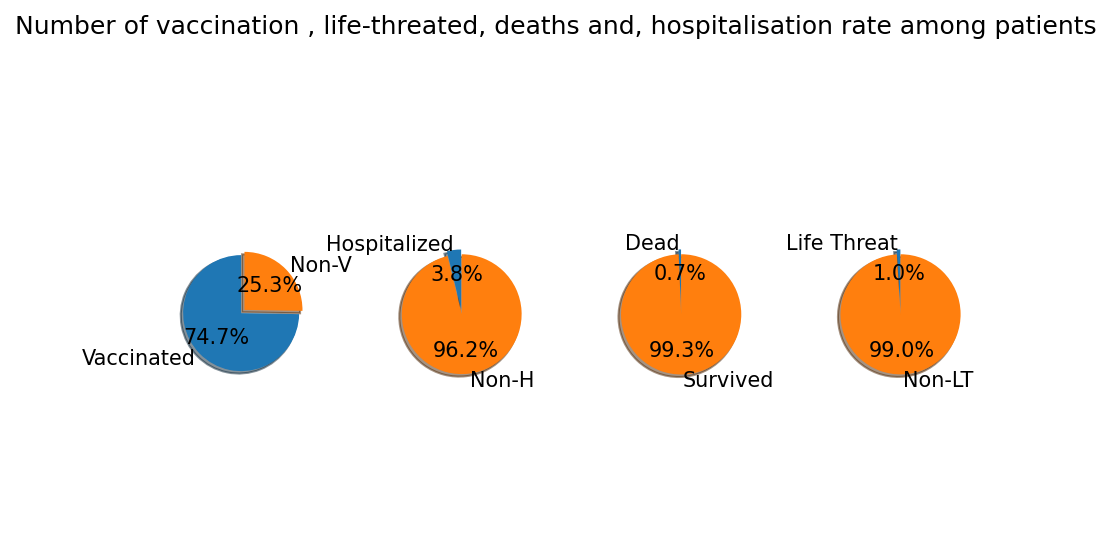

In [38]:
# survey number of vaccination , deaths and hospitalisation rate among patients

fig, (ax1, ax2 , ax3, ax4) = plt.subplots(1, 4,dpi=150,constrained_layout=True)
fig.suptitle('Number of vaccination , life-threated, deaths and, hospitalisation rate among patients')
fig.tight_layout()


all_patients= int(df_vax_and_data_and_sym.count()[0])
hospitalized_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["HOSPITAL"] == 1)]
l_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["L_THREAT"] == 1)]
vax_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["VAX_MANU"] == 0)]
dead_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["DIED"] == 1)]

#hospitalized_vax_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["HOSPITAL"] == 1) & (df_vax_and_data_and_sym["VAX_MANU"] == 0)]

count_hospitalized = int(hospitalized_patients["VAERS_ID_DATA"].nunique())
count_vax_patients = int(vax_patients["VAERS_ID_DATA"].nunique())
count_dead_patients = int(dead_patients["VAERS_ID_DATA"].nunique())
count_lt_patients = int(l_patients["VAERS_ID_DATA"].nunique())
#count_hospitalized_vax_patients = int(hospitalized_vax_patients["VAERS_ID_DATA"].nunique())


# labels_h_v = 'Vaccinated and Hospitalized', 'Others'
# sizes_h_v = [count_hospitalized_vax_patients, (all_patients-count_hospitalized_vax_patients)]

labels_l = 'Life Threat', 'Non-LT'
sizes_l = [count_lt_patients, (all_patients-count_lt_patients)]

labels_h = 'Hospitalized', 'Non-H'
sizes_h = [count_hospitalized, (all_patients-count_hospitalized)]

labels_v = 'Vaccinated', 'Non-V'
sizes_v = [count_vax_patients, (all_patients-count_vax_patients)]

labels_d = 'Dead', 'Survived'
sizes_d = [count_dead_patients, (all_patients-count_dead_patients)]

explode = (0.08, 0)

    
ax1.pie(sizes_v, explode=explode, labels=labels_v, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  

ax2.pie(sizes_h, explode=explode, labels=labels_h, autopct='%1.1f%%',shadow=True, startangle=90)
ax2.axis('equal')  

ax3.pie(sizes_d, explode=explode, labels=labels_d, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.axis('equal')  

ax4.pie(sizes_l, explode=explode, labels=labels_l, autopct='%1.1f%%',shadow=True, startangle=90)
ax4.axis('equal')  


# ax4.pie(sizes_h_v, explode=explode, labels=labels_h_v, autopct='%1.1f%%',shadow=True, startangle=90)
# ax4.axis('equal')  

# plt.show() 

<ipython-input-41-412558325d57>:5: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


(-1.1864150370185675,
 1.1052761843919068,
 -1.1022831776096427,
 1.1008361132619795)

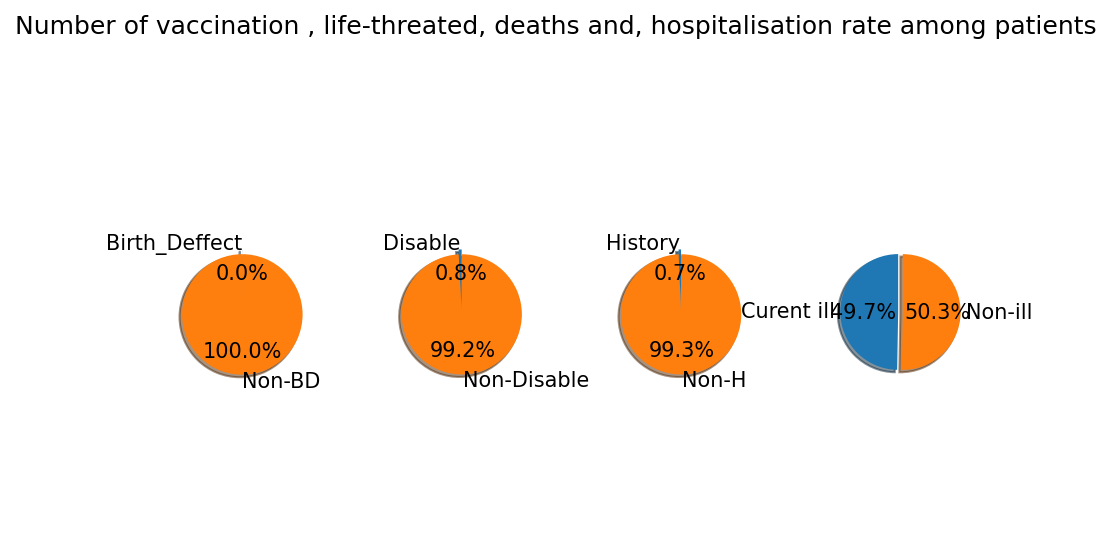

In [41]:
# survey number of vaccination , deaths and hospitalisation rate among patients

fig, (ax1, ax2 , ax3, ax4) = plt.subplots(1, 4,dpi=150,constrained_layout=True)
fig.suptitle('Number of vaccination , life-threated, deaths and, hospitalisation rate among patients')
fig.tight_layout()


all_patients= int(df_vax_and_data_and_sym.count()[0])
birth_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["BIRTH_DEFECT"] == 1)]
d_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["DISABLE"] == 1)]
his_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["HISTORY"] == 1)]
curr_patients = df_vax_and_data_and_sym[(df_vax_and_data_and_sym["CUR_ILL"] == 1)]


count_birth = int(birth_patients["VAERS_ID_DATA"].nunique())
count_d_patients = int(d_patients["VAERS_ID_DATA"].nunique())
count_his_patients = int(dead_patients["VAERS_ID_DATA"].nunique())
count_curr_patients = int(curr_patients["VAERS_ID_DATA"].nunique())


labels_b = 'Birth_Deffect', 'Non-BD'
sizes_b = [count_birth, (all_patients-count_birth)]

labels_dis = 'Disable', 'Non-Disable'
sizes_dis = [count_d_patients, (all_patients-count_d_patients)]

labels_his = 'History', 'Non-H'
sizes_his = [count_his_patients, (all_patients-count_his_patients)]

labels_cur = 'Curent ill', 'Non-ill'
sizes_cur = [count_curr_patients, (all_patients-count_curr_patients)]

explode = (0.08, 0)

    
ax1.pie(sizes_b, explode=explode, labels=labels_b, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  

ax2.pie(sizes_dis, explode=explode, labels=labels_dis, autopct='%1.1f%%',shadow=True, startangle=90)
ax2.axis('equal')  

ax3.pie(sizes_his, explode=explode, labels=labels_his, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.axis('equal')  

ax4.pie(sizes_cur, explode=explode, labels=labels_cur, autopct='%1.1f%%',shadow=True, startangle=90)
ax4.axis('equal')  


# ax4.pie(sizes_h_v, explode=explode, labels=labels_h_v, autopct='%1.1f%%',shadow=True, startangle=90)
# ax4.axis('equal')  

# plt.show() 

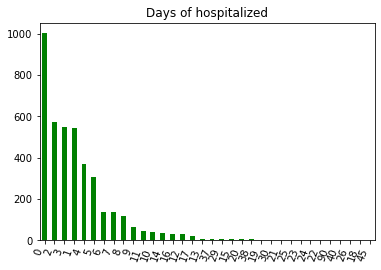

In [42]:
ax = hospitalized_patients["HOSPDAYS"].value_counts().plot(kind='bar', color='green')
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=70, horizontalalignment='right')
ax.set_title('Days of hospitalized')

plt.show()

1
9
14
8
0
0


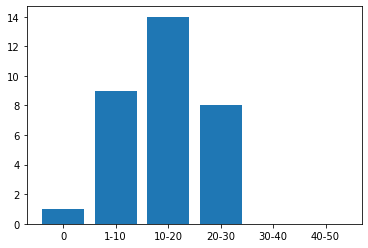

In [80]:
dys = dict(hospitalized_patients["HOSPDAYS"].value_counts())

zero_days = []
under_10 = []
ten_20 = []
ten_30 = []
ten_40 = []
ten_50 = []
for k,v in dys.items():
    if k ==0:
        zero_days.append(v)
    if k> 1 and k<=10:
        under_10.append(v)
    if k >10 and k<=20:
        ten_20.append(v)
    if k >20 and k<=30:
        ten_30.append(v)
    if k >30 and k<=40:
        ten_20.append(v)
    if k >40 and k<=50:
        ten_20.append(v)
    else:
        continue

data_dict = {
    '0':len(zero_days),
    '1-10': len(under_10),
    '10-20':len(ten_20),
    '20-30':len(ten_30),
    '30-40':len(ten_40),
    '40-50':len(ten_50)
}
day_labels , day_sizes = [] , []
for x, y in data_dict.items():
    day_labels.append(x)
    print(y)
    day_sizes.append(y)

plt.bar(*zip(*data_dict.items()))
#plt.grid(True)
plt.show()

# explode = (0.6,0,0,0,0,0)
# plt.pie(day_sizes, explode=explode, labels=day_labels, autopct='%1.1f%%',shadow=True, startangle=90)
# plt.axis('equal')  

plt.show()



In [ ]:
df_data_coor =df_vax_and_data_and_sym.drop(columns='VAERS_ID_DATA')

In [ ]:
# df_vax_and_data_and_sym = df_vax_and_data_and_sym[df_vax_and_data['AGE_YRS'].notna()]
# df_vax_and_data_and_sym[df_vax_and_data_and_sym.isnull().any(axis=1)]
df_data_coor =df_vax_and_data_and_sym.drop(columns='VAERS_ID_SYM')

In [ ]:
df_data_coor=df_vax_and_data_and_sym[['HOSPITAL','AGE_YRS', 'BIRTH_DEFECT', 'SEX', 'DISABLE','OTHER_MEDS','CUR_ILL','HISTORY','NUM_OF_SYM_SUB']]
# ['HOSPITAL','AGE_YRS', 'BIRTH_DEFECT', 'SEX', 'DISABLE','OTHER_MEDS','CUR_ILL','HISTORY']

## Data Correlation Analyze

### Computing the positive and negative correlations 

In [ ]:
# calculate the crrolation with the traget column *HOSPITAL*
correlations = df_data_coor.corrwith(df_data_coor.HOSPITAL)

# remove the correlations with vaule 1 *remove the correlation between HOSPITAL HOSPITAL*
correlations = correlations.drop('HOSPITAL')

# Split the correlations into positive and negative
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

# print the coorelations 
print('Most Positive Correlations:\n', positive_correlations)
print('\nMost Negative Correlations:\n', negative_correlations)

### Visaulize the Correlations 

In [ ]:
# plot the correlation 
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        rot = 45, grid = True)

plt.tick_params(bottom=False, left=False)
plt.gca().set_axisbelow(True)
plt.gca().yaxis.grid(True, color='#EEEEEE')
plt.gca().xaxis.grid(False)

plt.title('Correlation with HOSPITAL \n', horizontalalignment="center", fontstyle = "normal",  fontsize = "22")

## Prepare Data for fitting into selected model

### Split data into features and target column

In [ ]:
#set the target column
target = df_vax_and_data_and_sym["HOSPITAL"]
# X_STAY	BIRTH_DEFECT	SEX	DISABLE	DIED	L_THREAT	HOSPITAL	HOSPDAYS	OTHER_MEDS	CUR_ILL	HISTORY	VAX_MANU	VAERS_ID_SYM	NUM_OF_SYM_SUB
# set the features 
model_df = df_vax_and_data_and_sym.drop(columns=["HOSPITAL",'HOSPDAYS','VAERS_ID_DATA','VAERS_ID_SYM','DIED','L_THREAT'])

In [ ]:
model_df.columns

### Anaylze the Feature importances via coefficients using Ridge

In [ ]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(model_df, target)
importance = np.abs(ridge.coef_)
feature_names = model_df.columns
plt.bar(height=importance, x=feature_names,color=['red'])
plt.setp(plt.gca().get_xticklabels(), rotation=70, horizontalalignment='right')
plt.title("Feature importances via coefficients")
plt.grid(True)
plt.show()

### Selecting and Configuration the models 

The models below are more than the ones that we have shown in the paper. Since the there is a limit for the number of pages that we allow to write. We kept them here in Notebook 

In [ ]:
# training models 
model_1=['Random Forest',RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 92)]
#model_2=['SVM',SVC(kernel = 'rbf', random_state = 90)]
model_3= ['Logistic Regression',LogisticRegression(solver='liblinear', random_state = 105,class_weight='balanced')]
model_4= ['Decision Tree',DecisionTreeClassifier(criterion = 'entropy', random_state = 90)]
model_5 = ['Gradient Boosting Classifier',GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)]

#models=[model_1,model_2,model_3,model_4,model_5]
models= [model_1,model_3,model_4,model_5]

### Data Normalization

In [ ]:
# normalize the data 
sc_X = StandardScaler()

model_df_norm = pd.DataFrame(sc_X.fit_transform(model_df))

model_df_norm.columns = model_df.columns.values

model_df_norm.index = model_df.index.values

model_df_1 = model_df_norm

### Cross Validation for Models training 

In [ ]:
def cross_validation(X, y, model):
    
    X, y = np.array(X), np.array(y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        results.append(accuracy_score(y_test, y_hat))
        
    return np.mean(results), np.std(results)

In [ ]:

# a list for training infos 
traing_info=[]

for m in models:
    res=cross_validation(model_df_1,target,m[1])
    dict_model = {"model_name":m[0],"accuracy_mean":res[0],"accuracy_std":res[1]}
    traing_info.append(dict_model)

# create a new dataframe 
model_vali_df = pd.DataFrame()

# for each dict. in dict. list add to the last dataframe 
for l in traing_info:
    model_vali_df=model_vali_df.append(l, ignore_index=True)

### The results of the training 

The best model is Random forest. The result is surprising since the Gradient Boosting classifier has won more Kaggle challenges. 

In [ ]:
model_vali_df[['model_name','accuracy_mean', 'accuracy_std']].sort_values('accuracy_mean',ascending=False)

## More data understanding 

The figure below is plotting the number of hospitialization days and the age of the patient. Normally, we should see a linear relation between these data. But here we see a noised non-linear relation

In [ ]:
plt.scatter(df_vax_and_data_and_sym['AGE_YRS'], df_vax_and_data_and_sym['HOSPDAYS'], color='red')
plt.title('Age Vs Days of Hospitalisation', fontsize=14)
plt.xlabel('AGE_YRS', fontsize=14)
plt.ylabel('HOSPDAYS', fontsize=14)
plt.grid(True)
plt.show()